In [1]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/Machine_Learning/data') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [3]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

Cel: Klasyfikacja osób na ofiary (0) i osoby, które przeżyły (1).

Port (Embarked) nie ma znaczenia w kwestii założonego celu. Name też nie. Ticket oraz Cabin ciężko przewidzieć. (zakładając, że nie wnikamy w rozkład kabin na statku i odległość od kajut - pasażer też nie musiał być wtedy w kabinie). Poza tym są spore braki w Cabin (77% Nan) więc zakładanie dodatkowych rzeczy jest bezcelowe.

Występują braki w Fare oraz Age -  rozwiąże to robiąc medianę grupując po Pclass (klasy mają inne ceny biletów).

Typy danych można uprościć z .convert_dtypes() dla ułatwienia grupowania po płci. Pclass została zamieniona na kategorię, dla ułatwienia grupowania po niej.

Predykowana klasa to Survived.




In [4]:
def get_percentage_missing(df, axis):
  """
    Zwraca procent brakujących wartości (NaN) w wierszach lub kolumnach DataFrame.

    df : pandas.DataFrame
        Tabela danych, dla której liczone są braki.

    axis : int
        Oś, względem której obliczane są braki:
        - 0 : procent braków w każdej kolumnie
        - 1 : procent braków w każdym wierszu
  """
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]

In [5]:
titanic_df = titanic_df.drop(['Embarked', 'Name', 'Ticket', 'Cabin'], axis='columns') #usunięcie zbędnych kolumn

In [6]:
titanic_df.describe(include='all')


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,793.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,577,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,33.123938
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,51.578312
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.500000
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.275000


In [7]:
titanic_df = titanic_df.convert_dtypes()
titanic_df['Pclass'] = titanic_df['Pclass'].astype('category')

In [8]:

titanic_df.dtypes

,0
Survived,Int64
Pclass,category
Sex,string[python]
Age,Float64
SibSp,Int64
Parch,Int64
Fare,Float64


In [9]:
get_percentage_missing(titanic_df, 0)

,0
Age,19.87
Fare,11.00


In [10]:
median_fare_by_pclass = titanic_df.groupby('Pclass')['Fare'].transform('median') #transform wytworzy serię tej samej długości
median_age_by_pclass = titanic_df.groupby('Pclass')['Age'].transform('median')
titanic_df['Age'] = titanic_df['Age'].fillna(median_age_by_pclass) #uzupełnienie Nan
titanic_df['Fare'] = titanic_df['Fare'].fillna(median_fare_by_pclass)

/tmp/ipython-input-499726691.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_fare_by_pclass = titanic_df.groupby('Pclass')['Fare'].transform('median') #transform wytworzy serię tej samej długości
/tmp/ipython-input-499726691.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_age_by_pclass = titanic_df.groupby('Pclass')['Age'].transform('median')


Po oczyszczeniu zbioru - dodaje dwie kolumny FamilySize oraz na podstawie niej IsAlone (FamilySize == 1). Kolejno zakodowana zostanie kolumna Sex za pomocą klasyfikacji binarnej (female = 1, male = 0) oraz zakodowano one-hot Pclass

In [11]:
titanic_df['FamilySize'] = titanic_df.SibSp + titanic_df.Parch + 1 # +1 dla samego pasażera
titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int) # 1 dla samotnych, 0 dla tych z rodziną
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.25,2,0
2,1,1,female,38.0,1,0,71.2833,2,0
3,1,3,female,26.0,0,0,7.925,1,1
4,1,1,female,35.0,1,0,53.1,2,0
5,0,3,male,35.0,0,0,8.05,1,1
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0,1,1
888,1,1,female,19.0,0,0,30.0,1,1
889,0,3,female,24.0,1,2,23.45,4,0


In [12]:
titanic_df['Sex'] = titanic_df.Sex.map({
    'female': 1, 'male': 0
})
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.25,2,0
2,1,1,1,38.0,1,0,71.2833,2,0
3,1,3,1,26.0,0,0,7.925,1,1
4,1,1,1,35.0,1,0,53.1,2,0
5,0,3,0,35.0,0,0,8.05,1,1
...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,0,13.0,1,1
888,1,1,1,19.0,0,0,30.0,1,1
889,0,3,1,24.0,1,2,23.45,4,0


In [13]:
#pclass_dummies = pd.get_dummies(titanic_df['Pclass'], prefix='Pclass')
#titanic_df = pd.concat([titanic_df, pclass_dummies], axis=1)
#titanic_df[['Pclass_1', 'Pclass_2', 'Pclass_3']] = titanic_df[['Pclass_1', 'Pclass_2', 'Pclass_3']].astype(int)
titanic_df


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.25,2,0
2,1,1,1,38.0,1,0,71.2833,2,0
3,1,3,1,26.0,0,0,7.925,1,1
4,1,1,1,35.0,1,0,53.1,2,0
5,0,3,0,35.0,0,0,8.05,1,1
...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,0,13.0,1,1
888,1,1,1,19.0,0,0,30.0,1,1
889,0,3,1,24.0,1,2,23.45,4,0


Trzeba policzyć wartości skrajne dla numerycznych (Age, Fare, FamilySize) i kategorialnych (Pclass, Sex, IsAlone)

In [16]:
def plot_numeric_histogram(df, column_name):
    """
    Plots a histogram for the specified column in the DataFrame,
    and adds vertical lines for the mean and median.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    Returns:
        None. Displays the histogram.
    """

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def plot_categorical_column(df, column_name):
    """
    Plots a bar chart for the specified categorical column.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """

    # count occurrences of each category
    counts = df[column_name].value_counts()

    plt.figure(figsize=(6, 4))
    counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

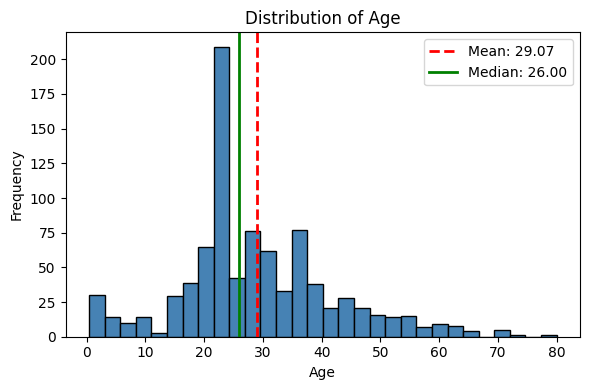

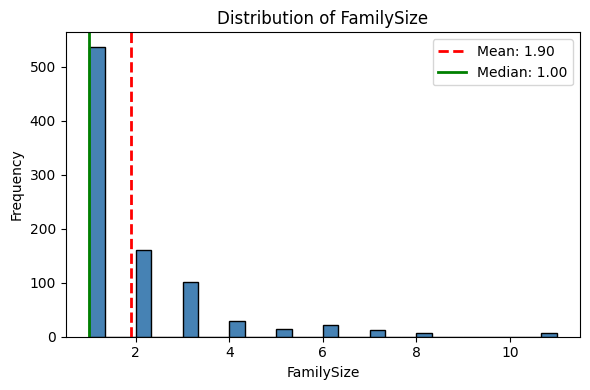

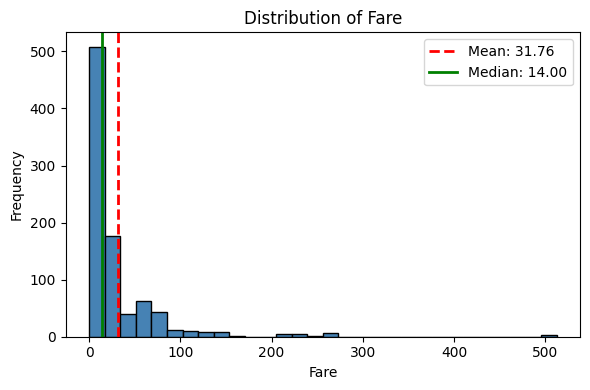

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_values = ['Age', 'FamilySize', 'Fare']
categorical_values = ['Pclass', 'Sex', 'IsAlone']

for column_name in numerical_values :
  plot_numeric_histogram(titanic_df, column_name)

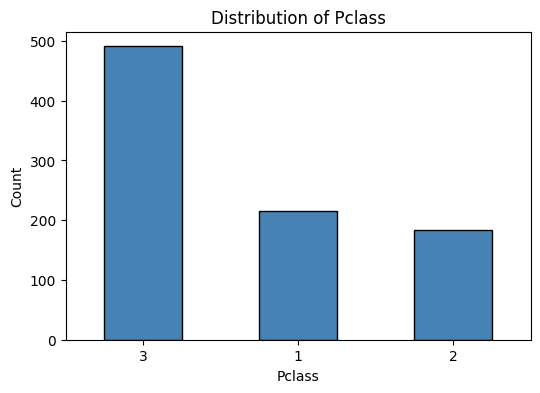

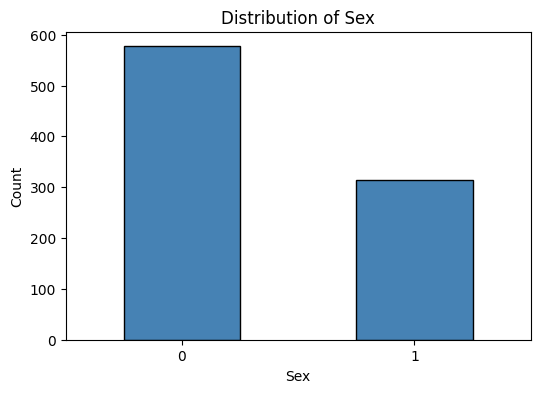

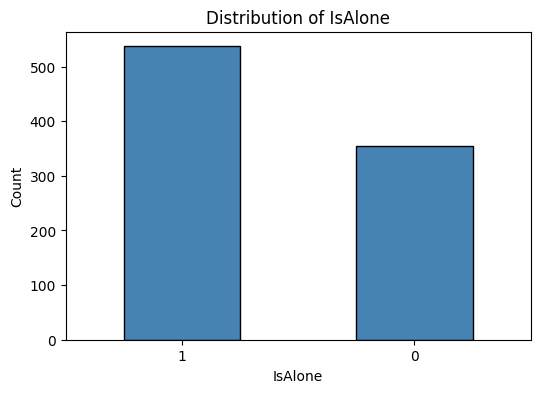

In [21]:
for column_name in categorical_values:
  plot_categorical_column(titanic_df, column_name)

Wykresy pokazują, że więcej jest młodych ludzi niż starszych, większość ludzi jest sama na statku, bilety kosztowały około 32, przewaga 3 klasy, mężczyzn.
Rozkład skośny występuje przy Fare i FamilySize. Kilku pasażerów zapłaciło więcej niż 200 za bilet - to outliery.


Można sprawdzić zależność zależności względem Survived takie jak: Age (czy wiek wpływa na przeżycie), Sex (czy kobiety były wpuszczane pierwsze na łodzie), FamilySize (czy ludzie z rodziną mieli większe szanse na przeżycie).

In [51]:
def countplot(df, column_a, column_b):
    sns.set(style="whitegrid")

    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=column_a, hue=column_b)
    plt.title(f'{column_a} vs {column_b}')
    plt.show()


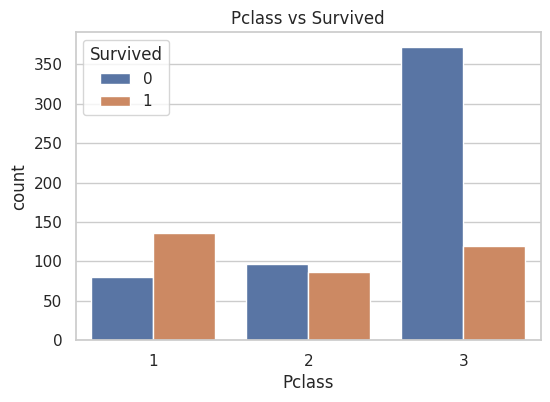

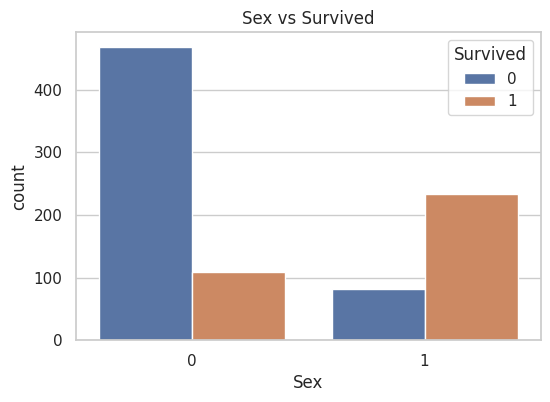

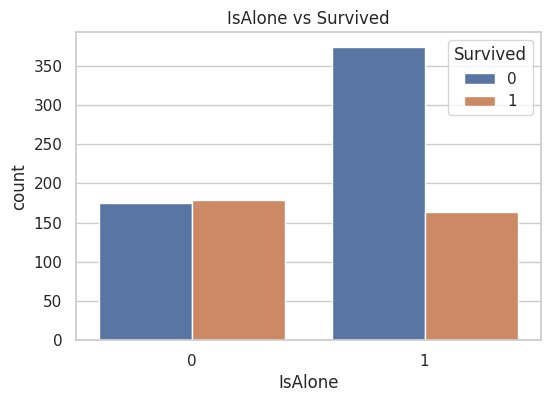

In [58]:
countplot(titanic_df, 'Pclass', 'Survived')
countplot(titanic_df, 'Sex', 'Survived')
countplot(titanic_df, 'IsAlone', 'Survived')

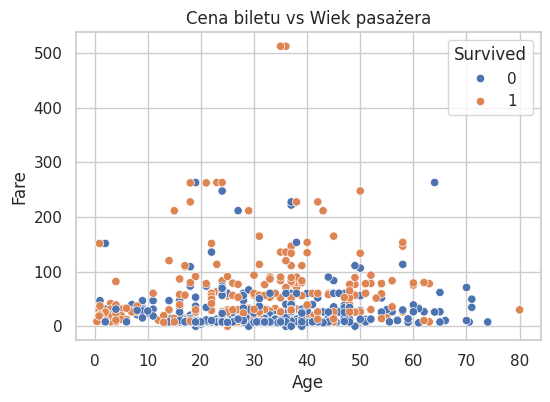

In [48]:
  plt.figure(figsize=(6,4))
  sns.scatterplot(data=titanic_df, x='Age', y='Fare', hue='Survived')
  plt.title('Cena biletu vs Wiek pasażera')
  plt.show()

In [60]:
def boxplot(data, column_a, column_b):
  plt.figure(figsize=(6,4))
  sns.boxplot(data=data, x=column_a, y=column_b)
  plt.title(f'{column_a} vs {column_b}')
  plt.show()

def violinplot(data, column_a, column_b):
  plt.figure(figsize=(6,4))
  sns.violinplot(data=data, x=column_a, y=column_b)
  plt.title(f'{column_a} vs {column_b}')
  plt.show()

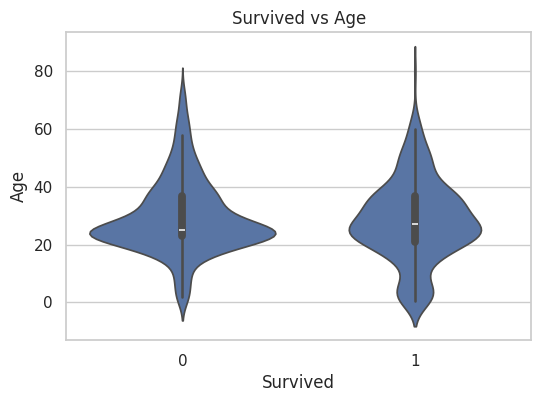

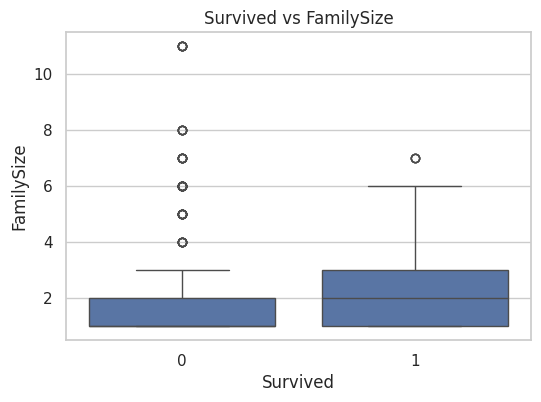

In [65]:
violinplot(titanic_df, 'Survived', 'Age')
boxplot(titanic_df, 'Survived', 'FamilySize')

Z wykresów można wywnioskować że:

*   więcej pasażerów 1 klasy przeżyło, w klasie 3 widzimy przewagę straconych żyć
*   przeżyło więcej kobiet, znacznie więcej mężczyzn zmarło
*   zmarło wiele osób, które było samych na statku - wartości zbliżone są dla osób z rodzinami
*    możemy zauważyć, że przeżyło więcej dzieci, niewiele starszych osób
*   jest kilka osób z drogimi biletami, które przeżyły (outlinery cenowe).
* mniejszy skład rodziny wpływa na przeżycie

